## Import the necessary libraries

* Modified Bessel functions of first kind and second kind documents: https://docs.scipy.org/doc/scipy/reference/special.html

* Detecting spikes documents: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html


In [99]:
import mpmath as mpmath
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv, kv  # import the modified first kind (iv) and second kind (kv) from scipy
from scipy.signal import find_peaks,argrelextrema

## Defining necessary functions
* Theta heavy side
* Extract information from file names
* Load data from files
* Find analytical peaks
* Shifting Function
* Peak and Smooth Operator

### Thete Heavyside Function

Let's define the function of theta heavyside
$$\theta(\omega) = \begin{cases} 
      1 & \omega > 0 \\
      0 & \omega \leq 0  
   \end{cases}$$

In [100]:
def theta_heavyside(omega): #done
    """This function defines a heavy step function of omega"""
    return 1 if omega >= 0 else 0 

### Extract information from file name

In [101]:
def extractinformation(file_name): #done
    """This function extracts information about 
    (Note that they are all in unit of m)
    T: temperature of the interaction m
    eB: Magnetic field created in the background m^2
    kT: Energy of the photon emission m
    input: file_name
    output: an array of information [eB, T, kT]
    """
    values = []
    value = ''
    for i in file_name:
        if (ord(i) < 47 or ord(i) > 58): # if not a number continue
            if value != '': # if the value is not empty
                values.append(int(value))
                value = ''
            continue
        else:  #if it is a number
            value = value + i # add the value
    values.append(int(value)) # add the last value
    return np.array(values)

file_name= 'eB25T5kT1' #our files are named in a specific way
data_constants = extractinformation(file_name)
print(data_constants)

[25  5  1]


### Extract theta and emission rate from data

In [102]:
from google.colab import files
uploaded = files.upload() ## upload files of data here to work with

Saving sample.dat to sample (2).dat


In [103]:
def load_data(lis): 
    """ Import a list of all file names that you want to unload
    return a list of x and y values as a list with respective index
    input: a list of file names
    output: an array of x and y values respectively within a list
    """
    unbox_lis = []
    tup = []
    for i in lis:
        data = np.loadtxt(i)
        x, y = np.split(data, 2, axis=1)
        x = x.flatten(); y= y.flatten()
        tup.append(x)
        tup.append(y) # append values of x and y for each index as a sublist
        unbox_lis.append(tup) # append the sublist to list
        tup = [] # reset
    return unbox_lis

#example
lis = ['sample.dat', 'sample2.dat', 'sample3.dat']
unbox = load_data(lis)
x_v, y_v = unbox[0][0], unbox[0][1] # unload x and y values from sample.dat

### Find the angular location of peaks analytically

On the mathematical derivation: 

In [104]:
def threshold_analy(data_constants, n_max = 450, process = 'splitting'): #done
    """ given the information of temperature (T), photon energy (kT), magnetic field (eB), we can analytically
    find the position of peaks of infinite rate.
    data_constants[0]: magnetic field strength
    data_constants[1]: Temperature
    data_constants[2]: energy of photon
    input: data_constants (which extracts from our file name)
        n_max: default at 450
        process: splitting or annihilation
    output: an array of landau transition which
    landau_transition[i][0]: n_prime, original level
    landau_transition[i][1]: n, excited level
    landau_transition[i][2]: angular coordinate position (theta)
    landau_transition[i][3]: process of emission
    """
    if process == 'splitting':
        r = 1
    else: # annihilation
        r = -1
    ratio = 1/data_constants[2]
    # use two for loops to check all possible values
    landau_transitions = []
    landau_transition = []
    for n_prime in range(n_max): #Let n max be 450
        for n in range(n_prime+1, n_max+1):
            expression = ratio * abs(np.sqrt(1+2*n*data_constants[0]) - r*np.sqrt(1+2*n_prime*data_constants[0]))
            if expression > 1:
                continue # skip for bigger than 1 since they will not give an answer
            landau_transition.append(n_prime)
            landau_transition.append(n) 
            landau_transition.append(np.arcsin(expression))
            landau_transition.append(process)
            landau_transitions.append(landau_transition)
            landau_transition = []
    return landau_transitions

# return the locations of all infinite emissions with n_max = 30
landau_transitions = threshold_analy(data_constants, process = 'splitting', n_max = 30)
landau_transitions_1 = threshold_analy(data_constants, process = 'annihilation', n_max = 30)
landau_transitions = landau_transitions + landau_transitions # all emission process

# show the Landau transition process
for i in landau_transitions:
    print(i)

[12, 13, 1.536162243409764, 'splitting']
[13, 14, 1.2931489741504245, 'splitting']
[14, 15, 1.1889403650707866, 'splitting']
[15, 16, 1.1142132132162026, 'splitting']
[16, 17, 1.0551230148641826, 'splitting']
[17, 18, 1.0061123236702458, 'splitting']
[18, 19, 0.9642574171858088, 'splitting']
[19, 20, 0.9277889620341186, 'splitting']
[20, 21, 0.8955389893127206, 'splitting']
[21, 22, 0.86668924794725, 'splitting']
[22, 23, 0.8406410759650238, 'splitting']
[23, 24, 0.8169417268309637, 'splitting']
[24, 25, 0.7952397323432173, 'splitting']
[25, 26, 0.7752563946661648, 'splitting']
[26, 27, 0.756766795429557, 'splitting']
[27, 28, 0.7395867006172132, 'splitting']
[28, 29, 0.7235632673539334, 'splitting']
[29, 30, 0.7085682861680587, 'splitting']
[12, 13, 1.536162243409764, 'splitting']
[13, 14, 1.2931489741504245, 'splitting']
[14, 15, 1.1889403650707866, 'splitting']
[15, 16, 1.1142132132162026, 'splitting']
[16, 17, 1.0551230148641826, 'splitting']
[17, 18, 1.0061123236702458, 'splitting

### Peak and Smooth Operator
* Peak operator transforms a smooth function to a peak
* Smooth function transforms a peak function to a smooth


We can transform a smooth function into a peak using the function
$$\frac{\theta(\Omega - \Omega_{thr})}{\sqrt{\Omega-\Omega_{thr}}} f(\Omega)$$ 
Where

$$\theta(\Omega - \Omega_{thr}) = \begin{cases} 
      1 & \Omega - \Omega_{thr} > 0 \\
      0 & \Omega - \Omega_{thr}\leq 0  
   \end{cases}$$

We could transform this formulation by using modified besseal functions. The formulation becomes 
$$\sqrt{\frac{\pi |\omega|}{8\gamma}} e^{\frac{-\omega^2}{4}}
    \left\{
    \theta (\omega) \left[ I_{-1/4}\left(\frac{\omega^2}{4}\right) + I_{1/4}\left(\frac{\omega^2}{4}\right)+ \frac{\sqrt{2}}{\pi}\theta (-\omega) K_{1/4}\left( \frac{\omega^2}{4} \right)
    \right]
    \right\} $$
Which will act on the smooth function 
to give the value of the peak function. $$f^{'}(\Omega_{thr})$$

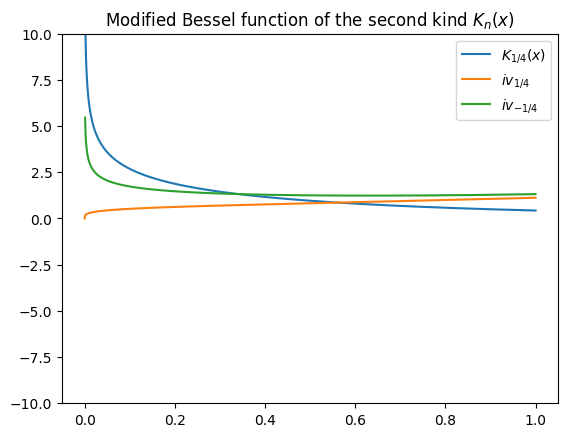

In [105]:

# Showing how the three modified bessel functions look like
# note that they can not handle negative values
x = np.linspace(0,1,1000)

plt.plot(x, kv(-1/4, x), label='$K_{1/4}(x)$')
plt.plot(x, iv(1/4, x), label = '$iv_{1/4}$')
plt.plot(x, iv(-1/4, x), label = '$iv_{-1/4}$')
plt.ylim(-10, 10)
plt.legend()
plt.title(r'Modified Bessel function of the second kind $K_n(x)$')
plt.show()

<ipython-input-106-0607121d4f46>:25: RuntimeWarning: divide by zero encountered in double_scalars
  prop = np.sqrt((np.pi * abs(omega))/(8*tau*np.sin(theta))) \
<ipython-input-106-0607121d4f46>:29: RuntimeWarning: invalid value encountered in double_scalars
  y_new.append(emiss_rate[i]*(prop*(theta_heavyside(omega)*i_terms+k_terms))) # add the new value to the list


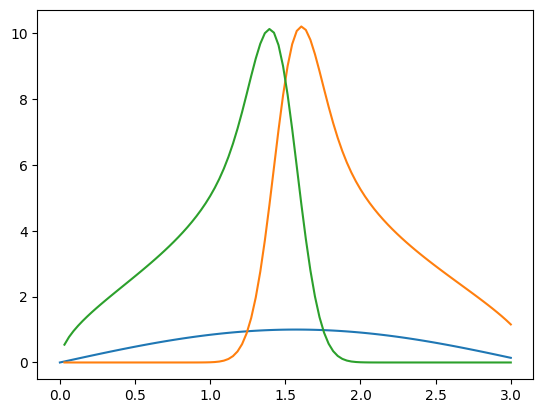

In [106]:
def peak_operator(theta_threshold, angu_depen, emiss_rate, data_constants, tau = 1, process = 'splitting'): #done
    """
    The function takes in the singularity points' properties such as:
    theta_threshold: sigularity's location
    angu_depen: range around sigularity
    emiss_rate: emission value at theta
    data_constants[2] = energy photon
    Return: new y values using modified bessel functions (peak)
    """
    # the width of quasiparticle is at default 1, but we can change it
    # determine what process is happening
    if process == 'splitting':
        flip = 1
    else:
        flip = -1  

    # Initialize the values   
    y_new = [] 
    i= 0 
    k = data_constants[2] * np.sin(theta_threshold)

    for theta in angu_depen: # run in a close range of the value
        omega = flip*(data_constants[2] * np.sqrt(data_constants[2]**2-k**2)) * (theta_threshold-theta+.0001) / (k * tau)
        # handling bessel functions at 0 will not be well so we add a small error range of .0001 to avoid 0 division
        prop = np.sqrt((np.pi * abs(omega))/(8*tau*np.sin(theta))) \
               * np.exp(-(omega**2)/4)  # define the term outside of curly bracket
        i_terms = iv(-1/4, (omega**2)/4) + iv(1/4, (omega**2)/4) # define the addition of two firt kind of order 1/4 and -1/4
        k_terms = (np.sqrt(2)/np.pi)*theta_heavyside(-omega)*kv(1/4,(omega**2)/4) # define the term including second kind of order 1/4
        y_new.append(emiss_rate[i]*(prop*(theta_heavyside(omega)*i_terms+k_terms))) # add the new value to the list
        i+=1
    return np.array(y_new) # return the array of new y values

#examples: if we want to make a peak similar to splitting process
#note that we can not deal with negative numbers using bessels since it will result in unexpected behaviors
smooth_x = np.linspace(0,3,100)
smooth_y = np.sin(smooth_x)
plt.plot(smooth_x,smooth_y) # smooth function (blue)
#we can also do it for annihilation process (orange)
peak_y = peak_operator(1.5, smooth_x, smooth_y, data_constants, tau = .01, process = 'annihilation')
plt.plot(smooth_x, peak_y)
# similarly for splitting (green)
peak_y = peak_operator(1.5, smooth_x, smooth_y, data_constants, tau = .01)
plt.plot(smooth_x,peak_y)


<ipython-input-107-3032fd36b5ed>:29: RuntimeWarning: divide by zero encountered in double_scalars
  prop = np.sqrt((np.pi * abs(omega))/(8*tau*np.sin(theta))) \


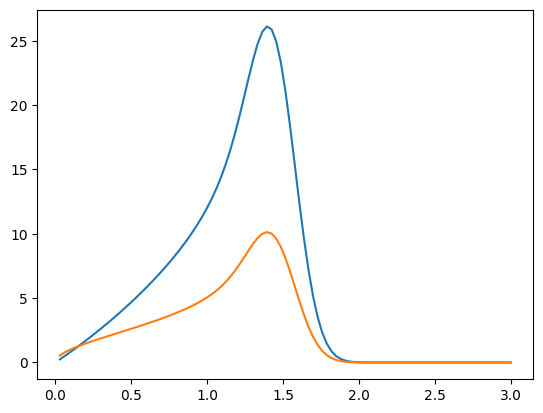

In [107]:
# one thing to be noticed is that we can not go back from peak to smooth function easily
# for splitting peaks, the left side will not be able to match backward
# for annihilation peaks, the right side will not be able to match backward
# Therefore, we transfer only half of the function while the other half is 0
def smooth_operator(theta_threshold, angu_depen, emiss_rate, data_constants, tau = 1, process = 'splitting'): 
    """
    The function takes in the singularity points' properties such as:
    theta_threshold: sigularity's location
    angu_depen: range around sigularity
    emiss_rate: emission value at theta
    data_constants[2] = energy photon
    Return: new y values using modified bessel functions (smooth)
    """
    # the width of quasiparticle is at default 1, but we can change it
    # determine what process is happening
    if process == 'splitting':
        flip = 1
    else:
        flip = -1  

    #initialize the values   
    y_new = [] 
    i= 0 
    k = data_constants[2] * np.sin(theta_threshold)

    for theta in angu_depen: # run in a close range of the value
        omega = flip*(data_constants[2] * np.sqrt(data_constants[2]**2-k**2)) * (theta_threshold-theta+.0001) / (k * tau)
        # adding .0001 to eliminate unexpected situation
        prop = np.sqrt((np.pi * abs(omega))/(8*tau*np.sin(theta))) \
               * np.exp(-(omega**2)/4)  # define the term outside of curly bracket
        i_terms = iv(-1/4, (omega**2)/4) + iv(1/4, (omega**2)/4) # define the addition of two firt kind of order 1/4 and -1/4
        k_terms = (np.sqrt(2)/np.pi)*theta_heavyside(-omega)*kv(1/4,(omega**2)/4) # define the term including second kind of order 1/4
        coef = (prop*(theta_heavyside(omega)*i_terms+k_terms))
        y_new.append(emiss_rate[i]/coef) # add the new value to the list
        i+=1
    return np.array(y_new) # return the array of new y values 

#example 
smooth_y = smooth_operator(1.5,smooth_x, peak_y, data_constants, tau = 5, process = 'splitting')
plt.plot(smooth_x, smooth_y) # smooth function is orange
plt.plot(smooth_x, peak_y) # peak function is blue
# note that the other side remains 0 as always since we can not reverse the process

In [108]:
def shifting(y_values, y_min): 
    """This function is used to shift back to the origin
    one could potentially add a negative value of y_min to tell this function
    to go back to origin/ back to where it was
    """
    j = 0
    for y in y_values:
        y_values[j] = y_values[j] - y_min
        j+=1
    return y_values

# Finding the peaks computationally

Even though we know the exact location of the peaks, it is not possible for these locations to match the values from data because of the resolution.

* arrgrelexteme document: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelextrema.html



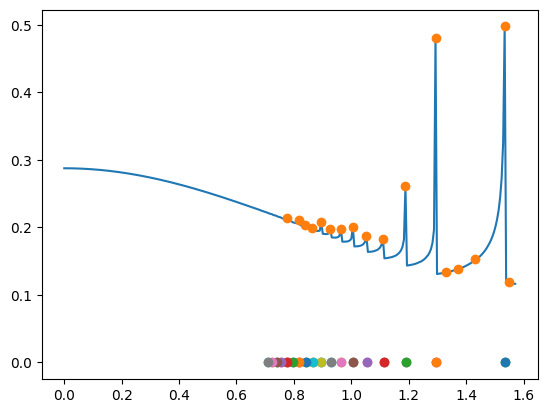

In [109]:
x_v, y_v = unbox[0][0], unbox[0][1] # unload x and y values from the first dataset

# get the indices of the peaks
max_indices = np.array(argrelextrema(y_v, np.greater)).flatten()

#Retreat the locations of all peaks
y_peaks, x_peaks = [], [] # empty to append
for peak_indice in max_indices:
    x_peaks.append(x_v[peak_indice])
    y_peaks.append(y_v[peak_indice])

# conversion to numpy for easier manipulation
x_peaks = np.array(x_peaks) 
y_peaks = np.array(y_peaks)

# plot the peaks from data
plt.plot(x_v,y_v)
plt.plot(x_peaks, y_peaks, 'o')

# plot the peaks from analytical method
for i in landau_transitions:
    plt.plot(i[2], 0,'o')

# uncomment if wanting to save the image
#plt.savefig('spikes.png')

#if we increase n_max, the locations of the peaks can be much more

### Finding peaks given a condition
Document: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

We can also develope other different conditions to locate the desire peak


In [110]:
# since we might get different results from actual peaks and peaks from data due to the 
#resolution when the data is created, we want to find the peak in data from the actual peak
def find_res_peak(x_peaks, actual_peak): #done
    """ Input the analytical thresholds and peaks from data
    return the peak from the data
    """
    x_min = 1
    for x in x_peaks:
        x_holder = abs(x - actual_peak)
        if x_holder < x_min:
            x_act = x
            x_min = x_holder
    return x_act
    
x_actual_peak = find_res_peak(x_peaks, 1.2931489741504245)
print(x_actual_peak)

1.2929503818529113


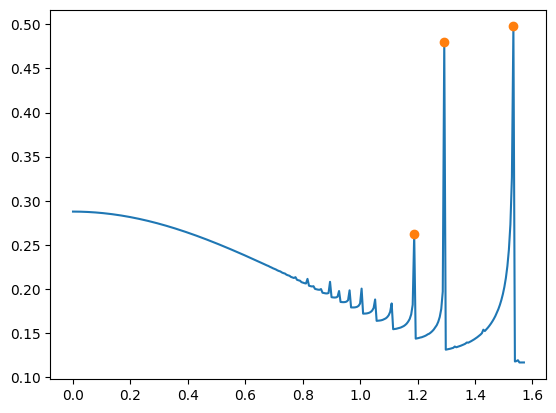

In [111]:
# finding peaks given the height condition
peaks, _ = find_peaks(y_v, height=.25)

# extracting the peaks location
y_peak_condition, x_peak_condition = [], []
for peak in peaks:
    x_peak_condition.append(x_v[peak])
    y_peak_condition.append(y_v[peak])

# convert to array for easier manip
y_peak_condition = np.array(y_peak_condition)
x_peak_condition = np.array(x_peak_condition)

#plot the peaks with height above .25 because handling smaller peaks could be quite a task
plt.plot(x_v, y_v, '-', x_peak_condition, y_peak_condition, 'o')


# An interesting smooth solution using savgol_filter

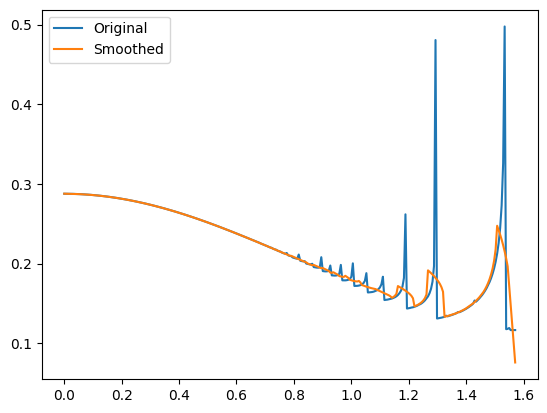

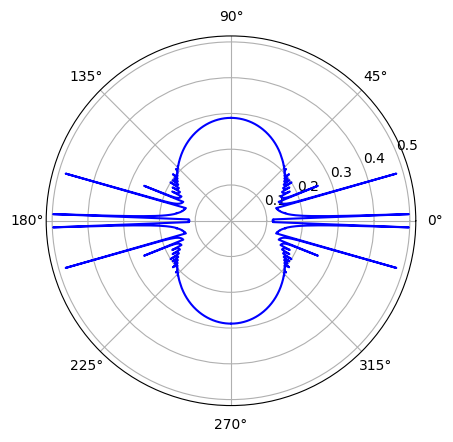

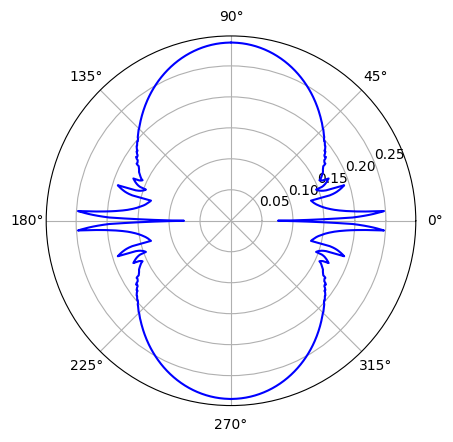

In [112]:
from scipy.signal import savgol_filter

# Define the size of the moving window for smoothing
window_size = 10

# Apply the moving average filter
y_smoothed = np.convolve(y_v, np.ones(window_size)/window_size, mode='same')
y_smoothed = savgol_filter(y_v, window_length=11, polyorder=1)

# Plot the original and smoothed data
plt.plot(x_v, y_v, label='Original')
plt.plot(x_v, y_smoothed, label='Smoothed')
plt.legend()
# uncomment to save plot
#plt.savefig('onepeak3.png')
plt.show()

#plot
def rad_plot(x_v,y_v):
  """
  This function is used to plot the data in a polar coordinate
  """
  new_x = list((-x_v+np.pi))
  new_x.reverse()
  x_v_1 = np.array(list(x_v) + new_x)
  new_y = list(y_v)
  new_y.reverse()
  y_v_1 = np.array(list(y_v)+new_y)
  fig = plt.figure()
  ax1 = fig.add_subplot(111, projection='polar')
  ax1.plot((x_v_1-np.pi/2), y_v_1, color = 'blue')
  ax1.plot((x_v_1+np.pi/2), y_v_1, color = 'blue')
  ax1.set_theta_direction(1)
  return fig

# plot the original emission rate
fig = rad_plot(x_v,y_v)

#uncomment to save the plot
#plt.savefig('onepeak2.png')

# plot the smoothed emission rate
fig1 = rad_plot(x_v,y_smoothed)

# uncomment to save the plot
#plt.savefig('onepeak1.png')

plt.show()

# Start simple with handling one peak

* While handling the peak, we want to preseve the area under the curve such that the emission stays the same


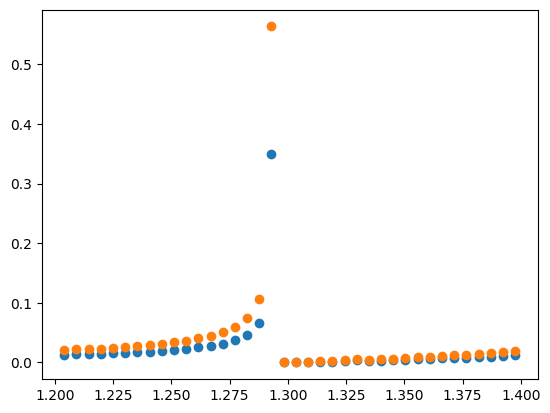

In [113]:
# give the width of quasipartical
tau = 2

def working_data(x_data,y_data, start, end):
  """
  This function is used to isolate one peak from the data 
  """
  i=0
  # locate one peak in the data and work with it
  x_one_peak = []
  y_one_peak = []
  for j in x_data:
      if (start) < j < (end):
          # retreat the data from the main data
          x_one_peak.append(j)
          y_one_peak.append(y_data[i])
      i+=1
  return np.array(x_one_peak), np.array(y_one_peak)

# getting values of the peak in a vector
x_one_peak, y_one_peak = working_data(x_v,y_v,1.2,1.4)

# get a copy for comparison later
x_one_peak_copy, y_one_peak_copy = working_data(x_v,y_v,1.2,1.4)

# shift the peak to line with the x axis
y_shifted = min(y_one_peak)
y_one_peak = shifting(y_one_peak, y_shifted)
y_one_peak_copy = shifting(y_one_peak_copy, y_shifted)

# getting the values of transformed
y_new_smooth = smooth_operator(1.296, x_one_peak, y_one_peak, data_constants,tau, process = 'splitting' )

#plot them
plt.plot(x_one_peak, y_one_peak,'o') #blue
plt.plot(x_one_peak, y_new_smooth,'o') #orange

## Find the area under the curve using trapezoid cummulative integration 
* Document: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapezoid.html

In [114]:
# cummulative intergration
from scipy.integrate import cumulative_trapezoid

# Compute the cumulative trapezoidal rule integration of the original peak
cumulative_integral_1 = cumulative_trapezoid(y_one_peak, x_one_peak)

# Print the result
print(f"The original emssion is: {cumulative_integral_1[-1]}")

The original emssion is: 0.004483065734042504


## Find the first half integral
* Document for inteporlation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html

In [115]:
# when working with the smooth rate, we cut off the values of 0 
cut_off = 1.29 # where the peak locates
x_one_peak_2, y_one_peak_2 = working_data(x_one_peak,y_one_peak,1.2,cut_off) #ignore the right side of the peak

# to get better integration, we interpolate to get more values
from scipy.interpolate import interp1d

#create an object for interpolation
f_interp = interp1d(x_one_peak_2, y_one_peak_2)
# generate more data
x_interp = np.linspace(min(x_one_peak_2)+.001, max(x_one_peak_2)-.001, num=100)
y_interp = f_interp(x_interp)



# use smooth operator to transform the value
y_interp = smooth_operator(1.296, x_interp, y_interp, data_constants,tau, process = 'splitting' )

# and we can find the integration
cumulative_integral_2 = cumulative_trapezoid(y_one_peak_2, x_one_peak_2)

#since we replace the right side by a gaussian profile
#find the integral of what the guassian profile should be
half_gaussian_integration = cumulative_integral_1[-1] - cumulative_integral_2[-1]

# Print the result
print(f"The cumulative integral on the left is: {cumulative_integral_2[-1]}")
print(f"The other gaussian has to have the integration: {half_gaussian_integration}")

The cumulative integral on the left is: 0.0019935870248172925
The other gaussian has to have the integration: 0.002489478709225212


## Find the second half shape

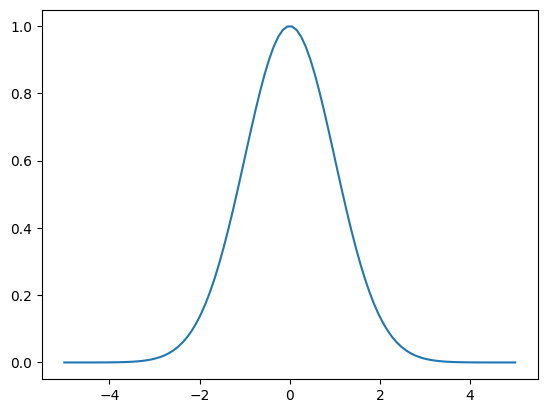

In [116]:
def gaussian(x,mu, sigma, amplitude):
  """
  This function defines the shape of a gaussian function
  """
  exp_term = -((x-mu)**2)/(2*(sigma**2))
  return amplitude * np.exp(exp_term)

#an example
x = np.linspace(-5,5,100)
y = gaussian(x,0,1,1)
plt.plot(x,y)

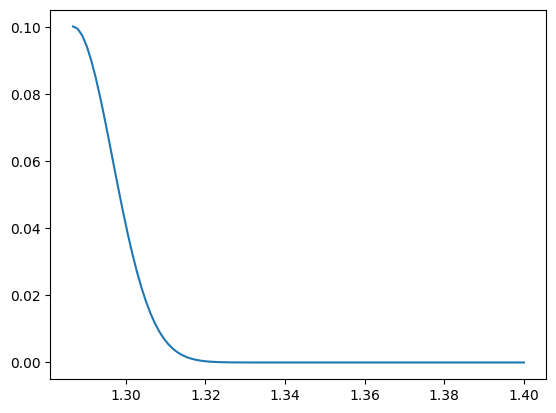

In [117]:
# finding what tau of the gaussian should be
tau_half = np.sqrt(((half_gaussian_integration / y_interp[-1])**2) * (1/(2*np.pi))) 

# Define the parameters of the Gaussian function
mu = x_interp[-1]  # mean
sigma = tau_half 
amplitude = y_interp[-1]

# generate the function
x = np.linspace(x_interp[-1], 1.4,100)
y = gaussian(x, mu, sigma, amplitude)

# Plot the Gaussian function
plt.plot(x, y)
plt.show()

## Combinning them together/ Final one peak product


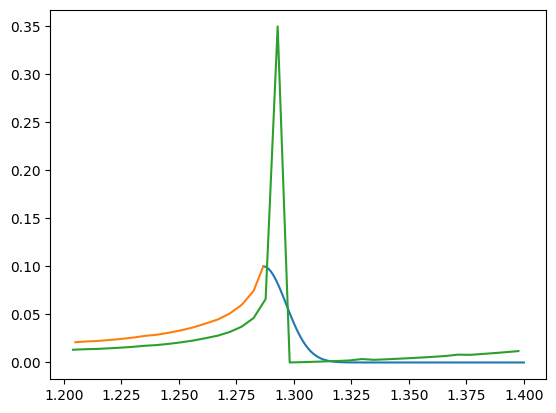

In [118]:
#plot the smooth function
plt.plot(x,y)
plt.plot(x_interp, y_interp)

#plot the peak 
plt.plot(x_one_peak_copy, y_one_peak_copy)

In [119]:
# return them to original position
y_interp = shifting(y_interp, -y_shifted)
y_one_peak_2_copy = shifting(y_one_peak_copy, -y_shifted)
y = shifting(y, -y_shifted)

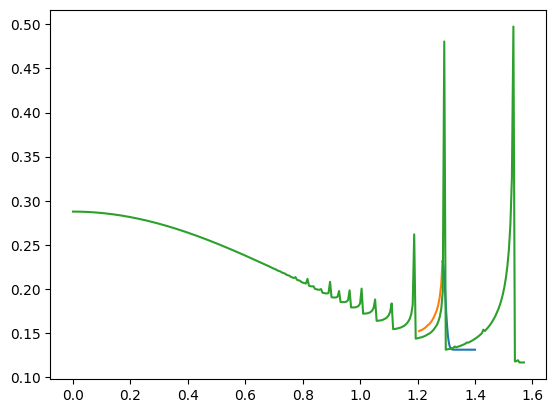

In [120]:
#plot the transformed emission
plt.plot(x,y)
plt.plot(x_interp, y_interp)

# plot the peaks
plt.plot(x_v,y_v)

We can essentially use the code above to solve any peak into an smooth function. However, the problem still lies in how all the smooth functions can be continuous all together. From our mathematical derivation, it is not possible to do so since the values can only be equal at the range of infinity.  